# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


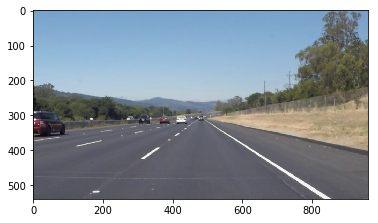

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
class line_finder():
    def __init__(self):
        # parameters
        self.rho = 1
        self.theta = np.pi/180
        self.threshold = 10
        self.min_line_len = 10
        self.max_line_gap = 200
        self.result = None
        self.color = [0,0,255]
        self.thickness = 10
        self.isBorderFinded = False
        self.old_m1 = None
        self.old_b1 = None
        self.old_m2 = None
        self.old_b2 = None
        self.ysize = 540
        self.xsize = 960
        self.th = 0.08
        
    # Calculates the line function that passes 2 points.  y = mx +b 
    def line_fit(self,line):
        x1,y1,x2,y2 = tuple(line[0])
        if (x1-x2) :
            m = float(y1-y2) /(x1-x2)
        else:
            m = 0
        b = y1-m*x1
        return m,b
    
    # preprocess image: convert image hsv color space and get v layer.   
    def pp_image(self,image):
        # Resize image
        image = cv2.resize(image,(self.xsize,self.ysize))
        self.img = image.copy()
        hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        # threshold v layer with 226 - only bright color remains
        v[v<226] = 0
        v[v>=226] = 255
        self.gray = v
        # We need a single channel image for hough lines so we sent this one channel.
        return v
    
    # Calculate mean and std to get a certain range of lines in our hand 
    # Narrow x sample with purify.   
    def purify(self,x):
        mn = np.mean(x)
        st = np.std(x)
        thresh = 0.01*mn
        while st > thresh:
            x =x[x>mn-st]
            x =x[x<mn+st]
            if len(x) == 0 :
                break
            mn = np.mean(x)
            st = np.std(x)         
        return mn    

    """
    Lines are detected with hough lines
    Calculates the slope and fixed values of all the lines found with line_fit
    If there are fewer than 10 lines founded, it returns a false
    If there are fewer lines in that one frame then that frame can continue with the previous line
    """
    def get_lines(self,img):
        lines = cv2.HoughLinesP(img, self.rho, 
                                self.theta, self.threshold, np.array([]), 
                                minLineLength=self.min_line_len, 
                                maxLineGap=self.max_line_gap)
        
        if( len(lines) < 10):
            return False
      
        self.ms = np.zeros(len(lines))
        self.bs = np.zeros(len(lines))
        i = 0
        for line in lines:
            m,b = self.line_fit(line)
            self.ms[i] = m
            self.bs[i] = b
            i += 1
            
        return True
    
    # Split right and left border line from line cluster
    def get_borders(self):   
        
        # Those with negative slopes
        m1 = self.ms[self.ms<0] 
        m1 = self.purify(m1)
        b1 = self.bs[self.ms<0]
        b1 = self.purify(b1)
        
        # Those with positive slopes
        m2 = self.ms[self.ms>0] 
        m2 = self.purify(m2)
        b2 = self.bs[self.ms>0]
        b2 = self.purify(b2) 
        """
        In order to prevent line ramble:
        1. calculate abs value of delta1 (m1), delta1_b, delta2 (m2), and delta2_b
        2. if delta value is higher than self.th value use previous m1,b1,m2,b2 values 
        """         
        if self.isBorderFinded :
            delta1 = abs((m1-self.old_m1)/self.old_m1)  
            delta1_b = abs((b1-self.old_b1)/self.old_b1) 
            if delta1 > self.th or delta1_b > self.th :
                # For tracking right lane value changes print current m1 value and old value
                print ('(1) ',m1,self.old_m1)
                m1 = self.old_m1
                b1 = self.old_b1
                    
                
            delta2 = abs((m2-self.old_m2)/self.old_m2)
            delta2_b = abs((b2-self.old_b2)/self.old_b2)
            if delta2 > self.th or delta2_b > self.th :
                # For tracking left lane value changes print current m1 value and old value
                print ('(2) ',m1,self.old_m1)
                m2 = self.old_m2
                b2 = self.old_b2
        
        """
        get_points calculates the x values from given slopes and constant values for image y size 
        and line lenght limit y point
        """
        self.pleft1,self.pleft2 = self.get_points(m1,b1)
                
        self.pright1,self.pright2 = self.get_points(m2,b2)
        
        self.isBorderFinded = True
        self.old_m1 = m1
        self.old_b1 = b1
        self.old_m2 = m2
        self.old_b2 = b2
           
    # Draw border lines and combine them with the main image        
    def draw_borders(self): 
        # Create an blank image
        line_img = np.zeros((self.img.shape[0], self.img.shape[1], 3), dtype=np.uint8)  
        # Draw right and left lines to blank image
        cv2.line(line_img, self.pleft1,self.pleft2, self.color, self.thickness)
        cv2.line(line_img, self.pright1,self.pright2, self.color, self.thickness)
        # Combine original image with %20 and border line with %80
        result = cv2.addWeighted(self.img, 0.2, line_img,0.8, 5)
        return result
    
    # In order limit border line lenght y size limited with a constant multiplier-0.63     
    # Calculates x values for line function that are given m and b values
    def get_points(self,m,b):
        y1 = int(self.ysize-1)
        x1 = int((y1-b)/m)
        y2 = int(self.ysize*0.63)
        x2 = int((y2-b)/m)
        return (x1,y1),(x2,y2)   
    
    #This main function to process image
    def process(self,image):        
        gray = self.pp_image(image)
        succes = self.get_lines(gray)
        if succes :
            #print ('succes')
            self.get_borders()
            result = self.draw_borders()
        elif isBorderFinded == False :
            #print ('Not succes No draw')
            result = self.img
        else:
            #print ('Old Borders used')
            result = self.draw_borders()  
        result = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)    
        return result
        

In [6]:
#Call line finder class
prc = line_finder()
def process_image(image):
    try:
        result = prc.process(image)
    except Exception as e:
        print(' error occured ',e.message)
        result = image
    return result

solidWhiteRight.jpg


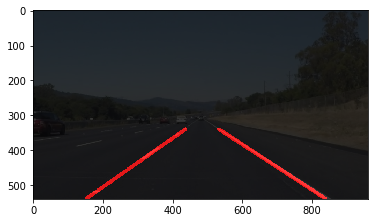

whiteCarLaneSwitch.jpg
(2)  -0.752508361204 -0.697837269114


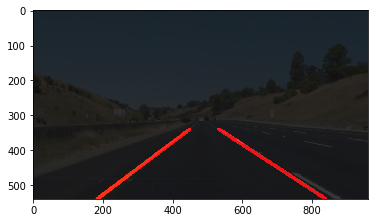

solidYellowLeft.jpg
(2)  -0.725373134328 -0.752508361204


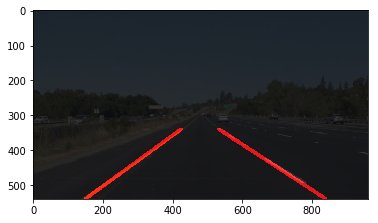

solidWhiteCurve.jpg
(2)  -0.782178217822 -0.725373134328


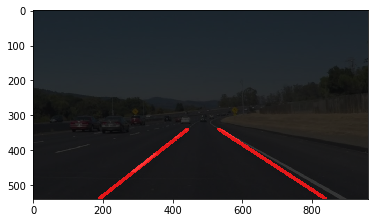

solidYellowCurve.jpg
(2)  -0.723215287911 -0.782178217822


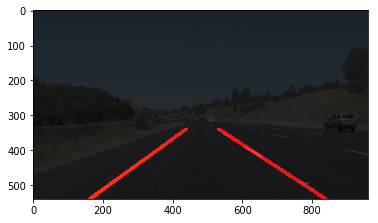

solidYellowCurve2.jpg
(1)  -0.776536312849 -0.723215287911
(2)  -0.723215287911 -0.723215287911


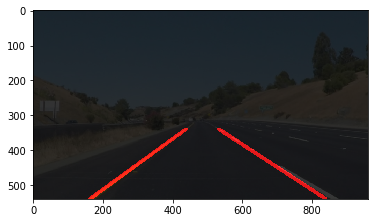

In [7]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
import os
# after image process save test images to path directory
path = 'test_images_output/'
images = os.listdir('test_images/')
if not os.path.exists(path):
    os.mkdir(path)
for img in images:
    print(img)
    image = cv2.imread("test_images/"+img)
    result = process_image(image)
    cv2.imwrite(path+img, result)
    plt.imshow(result)
    plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

(1)  -0.822478991597 -0.723215287911
(2)  -0.723215287911 -0.723215287911
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  2%|▏         | 4/222 [00:00<00:05, 36.54it/s]

(1)  -0.822478991597 -0.723215287911
(2)  -0.723215287911 -0.723215287911
(2)  -0.694444444444 -0.723215287911
(1)  -0.807255244755 -0.694444444444
(2)  -0.694444444444 -0.694444444444
(1)  -0.750957854406 -0.694444444444
(2)  -0.694444444444 -0.694444444444
(2)  -0.703389830508 -0.694444444444
(2)  -0.75237348663 -0.703389830508
(1)  -0.655172413793 -0.75237348663
(2)  -0.75237348663 -0.75237348663
(1)  -0.166666666667 -0.75237348663
(2)  -0.75237348663 -0.75237348663


  5%|▍         | 10/222 [00:00<00:05, 41.18it/s]

(2)  -0.75 -0.75237348663
(2)  -0.728813559322 -0.75
(2)  -0.723390342052 -0.728813559322


  7%|▋         | 16/222 [00:00<00:04, 45.07it/s]

(2)  -0.674165824065 -0.723390342052
(1)  -0.752384412753 -0.674165824065
(2)  -0.674165824065 -0.674165824065
(1)  -0.9 -0.724409448819
(2)  -0.724409448819 -0.724409448819
(2)  -0.699453551913 -0.724409448819
(2)  -0.699588477366 -0.699453551913
(1)  -0.0952380952381 -0.699588477366
(2)  -0.699588477366 -0.699588477366
(2)  -0.655 -0.699588477366
(1)  -0.725952645209 -0.655
(2)  -0.655 -0.655


 10%|▉         | 22/222 [00:00<00:04, 47.80it/s]

(2)  -0.698113207547 -0.700828729282
(2)  -0.652146464646 -0.698113207547


 13%|█▎        | 28/222 [00:00<00:03, 50.82it/s]

(1)  -0.722891566265 -0.652146464646
(2)  -0.652146464646 -0.652146464646
(2)  -0.700840336134 -0.652146464646
(2)  -0.699248120301 -0.700840336134
(2)  -0.675159235669 -0.699248120301
(2)  -0.675 -0.675159235669
(2)  -0.726872246696 -0.675
(2)  -0.719512195122 -0.726872246696
(2)  -0.701123595506 -0.719512195122
(2)  -0.673611111111 -0.701123595506
(2)  -0.701615529933 -0.673611111111


 15%|█▌        | 34/222 [00:00<00:03, 50.80it/s]

(1)  -0.590992647059 -0.701615529933
(2)  -0.701615529933 -0.701615529933
(2)  -0.726708074534 -0.701615529933


 18%|█▊        | 40/222 [00:00<00:03, 52.43it/s]

(2)  -0.678832116788 -0.728112757622
(2)  -0.700649350649 -0.675675675676
(2)  -0.72404120298 -0.700649350649


 21%|██        | 46/222 [00:00<00:03, 47.48it/s]

(2)  -0.724324324324 -0.689077669903
(2)  -0.752469904525 -0.724324324324
(1)  -0.967255075022 -0.752469904525
(2)  -0.752469904525 -0.752469904525
(2)  -0.775862068966 -0.752469904525
(2)  -0.75 -0.775862068966
(1)  -0.678955714124 -0.75
(2)  -0.75 -0.75
(2)  -0.727272727273 -0.75


 23%|██▎       | 51/222 [00:01<00:04, 42.09it/s]

(2)  -0.724859550562 -0.675213675214
(2)  -0.75 -0.733333333333


 25%|██▌       | 56/222 [00:01<00:03, 42.16it/s]

(1)  -0.675 -0.75
(2)  -0.75 -0.75
(2)  -0.725985634477 -0.75
(2)  -0.7237421023 -0.725985634477
(2)  -0.698113207547 -0.7237421023
(2)  -0.752049180328 -0.698113207547
(1)  -0.239047619048 -0.752049180328
(2)  -0.752049180328 -0.752049180328
(2)  -0.700934579439 -0.752049180328


 27%|██▋       | 61/222 [00:01<00:03, 43.28it/s]

(2)  -0.65 -0.700934579439
(2)  -0.701923076923 -0.65


 30%|██▉       | 66/222 [00:01<00:04, 38.40it/s]

(1)  -0.6 -0.701923076923
(2)  -0.701923076923 -0.701923076923
(2)  -0.698744769874 -0.701923076923
(2)  -0.649484536082 -0.698744769874
(2)  -0.697677499117 -0.649484536082
(2)  -0.741935483871 -0.697677499117


 32%|███▏      | 70/222 [00:01<00:04, 35.93it/s]

(1)  -0.673728813559 -0.741935483871
(2)  -0.741935483871 -0.741935483871
(2)  -0.695652173913 -0.741935483871


 33%|███▎      | 74/222 [00:01<00:04, 35.97it/s]

(1)  -0.625 -0.695652173913
(2)  -0.695652173913 -0.695652173913
(2)  -0.65 -0.695652173913
(2)  -0.666666666667 -0.65
(2)  -0.669412702631 -0.666666666667
(2)  -0.695652173913 -0.669412702631
(2)  -0.666666666667 -0.695652173913


 36%|███▌      | 79/222 [00:01<00:03, 39.11it/s]

(2)  -0.625 -0.666666666667
(2)  -0.645833333333 -0.625
(2)  -0.6 -0.645833333333


 38%|███▊      | 84/222 [00:01<00:03, 40.82it/s]

(1)  -0.69962406015 -0.6
(2)  -0.6 -0.6
(1)  -0.230769230769 -0.6
(2)  -0.6 -0.6
(2)  -0.641428571429 -0.6
(2)  -0.647887323944 -0.641428571429
(1)  -0.58904109589 -0.647887323944
(2)  -0.647887323944 -0.647887323944
(2)  -0.64953271028 -0.647887323944
(2)  -0.673758865248 -0.64953271028
(2)  -0.673273155416 -0.673758865248
(1)  -0.583800841515 -0.673273155416
(2)  -0.673273155416 -0.673273155416


 43%|████▎     | 95/222 [00:02<00:03, 42.30it/s]

(2)  -0.657657657658 -0.673273155416
(2)  -0.621155638397 -0.657657657658
(2)  -0.661363636364 -0.621155638397
(2)  -0.650220726589 -0.661363636364
(2)  -0.650498659068 -0.650220726589
(1)  -0.783950617284 -0.650498659068
(2)  -0.650498659068 -0.650498659068
(2)  -0.652694610778 -0.650498659068
(2)  -0.67484939759 -0.652694610778
(2)  -0.674200799201 -0.67484939759
(2)  -0.673913043478 -0.674200799201


 45%|████▌     | 100/222 [00:02<00:02, 41.78it/s]

(2)  -0.697363349009 -0.673913043478
(1)  -0.628535553793 -0.697363349009
(2)  -0.697363349009 -0.697363349009
(2)  -0.651757454606 -0.697363349009
(1)  -0.0666666666667 -0.651757454606
(2)  -0.651757454606 -0.651757454606
(2)  -0.697368421053 -0.651757454606


 47%|████▋     | 105/222 [00:02<00:02, 40.80it/s]

(1)  -0.189820359281 -0.697368421053
(2)  -0.697368421053 -0.697368421053
(1)  -0.0666666666667 -0.697368421053
(2)  -0.697368421053 -0.697368421053
(1)  -0.0741758241758 -0.697368421053
(2)  -0.697368421053 -0.697368421053
(2)  -0.700010974539 -0.697368421053


 50%|████▉     | 110/222 [00:02<00:02, 38.82it/s]

(1)  -0.0909090909091 -0.700010974539
(2)  -0.700010974539 -0.700010974539
(2)  -0.700521186786 -0.700010974539
(2)  -0.673151750973 -0.700521186786
(2)  -0.720588235294 -0.673151750973
(2)  -0.75 -0.720588235294
(1)  -0.551105548602 -0.75


 54%|█████▎    | 119/222 [00:02<00:02, 39.37it/s]

(1)  -0.0689655172414 -0.75
(2)  -0.75 -0.75
(2)  -0.700934579439 -0.75
(1)  -0.0715197956577 -0.700934579439
(2)  -0.700934579439 -0.700934579439
(2)  -0.723404255319 -0.724135220126
(1)  -0.575757575758 -0.723404255319
(2)  -0.723404255319 -0.723404255319
(2)  -0.68115942029 -0.723404255319
(2)  -0.67264573991 -0.68115942029
(2)  -0.673485635168 -0.67264573991
(2) 

 56%|█████▌    | 124/222 [00:02<00:02, 39.25it/s]

 -0.67457969381 -0.673485635168
(2)  -0.65 -0.671875
(1)  -0.0342105263158 -0.65
(2)  -0.65 -0.65
(1)  -0.0815649867374 -0.65
(2)  -0.6 -0.65
(1)  

 58%|█████▊    | 129/222 [00:03<00:02, 37.50it/s]

-0.0909090909091 -0.6
(2)  -0.6 -0.6


 60%|█████▉    | 133/222 [00:03<00:02, 37.63it/s]

(1)  -0.152173913043 -0.6
(2)  -0.6 -0.6
(1)  -0.7 -0.6
(2)  -0.6 -0.6
(1)  -0.650793650794 -0.6
(2)  -0.6 -0.6
(1)  -0.7 -0.6
(2)  -0.6 -0.6
(1)  -0.674242424242 -0.6
(2)  -0.6 -0.6
(1)  -0.699395867476 -0.6
(2)  -0.6 -0.6
(1)  -0.764705882353 -0.6
(2)  -0.6 -0.6


 62%|██████▏   | 138/222 [00:03<00:02, 39.52it/s]

(1)  -0.712522137723 -0.6
(2)  -0.6 -0.6
(1)  -0.698643141613 -0.6
(2)  -0.6 -0.6


 64%|██████▍   | 143/222 [00:03<00:02, 38.67it/s]

(1)  -0.120192307692 -0.6
(2)  -0.6 -0.6
(1)  -0.699593495935 -0.6
(2)  -0.6 -0.6
(1)  -0.7 -0.6
(2)  -0.6 -0.6
(1)  -0.722978815391 -0.6
(2)  -0.6 -0.6
(1)  -0.719298245614 -0.6
(2)  -0.6 -0.6
(1)  -0.1041779707 -0.6
(2)  -0.6 -0.6
(1)  -0.722222222222 -0.6
(2)  -0.6 -0.6
(1)  -0.75 -0.6
(2)  -0.6 -0.6


 68%|██████▊   | 151/222 [00:03<00:01, 36.65it/s]

(1)  -0.675047140163 -0.6
(2)  -0.6 -0.6
(1)  -0.7 -0.6
(2)  -0.6 -0.6
(1)  -0.727848101266 -0.6
(2)  -0.6 -0.6
(1)  -0.118811881188 -0.6
(2)  -0.6 -0.6
(1)  -0.702702702703 -0.6
(2)  -0.6 -0.6
(1)  -0.751068376068 -0.6
(2)  -0.6 -0.6
(1)  -0.725402298851 -0.6
(2)  -0.6 -0.6


 70%|██████▉   | 155/222 [00:03<00:01, 33.54it/s]

(1)  -0.700980392157 -0.6
(2)  -0.6 -0.6
(1)  -0.934306569343 -0.6
(2)  -0.6 -0.6
(1)  -0.742857142857 -0.6
(2)  -0.6 -0.6
(1)  -0.753191489362 -0.6
(2)  -0.6 -0.6


 72%|███████▏  | 159/222 [00:03<00:01, 31.92it/s]

(1)  -0.753116631268 -0.6
(2)  -0.6 -0.6
(1)  -0.727272727273 -0.6
(2)  -0.6 -0.6


 74%|███████▍  | 164/222 [00:04<00:01, 34.89it/s]

(1)  -0.900216450216 -0.6
(2)  -0.6 -0.6
(1)  -0.751633986928 -0.6
(2)  -0.6 -0.6
(1)  -0.748466257669 -0.6
(2)  -0.6 -0.6
(1)  -0.724489795918 -0.6
(2)  -0.6 -0.6
(1)  -0.215250965251 -0.6
(2)  -0.6 -0.6
(1)  -0.752525252525 -0.6
(2)  -0.6 -0.6
(1)  -0.752808988764 -0.6
(2)  -0.6 -0.6
(1)  -0.0534129332206 -0.6
(2)  -0.6 -0.6
(1)  -0.46231884058 -0.6
(2)  -0.6 -0.6


 76%|███████▌  | 169/222 [00:04<00:01, 35.93it/s]

(1)  -0.774193548387 -0.6
(2)  -0.6 -0.6
(1)  -0.752632745815 -0.6
(2)  -0.6 -0.6
(1)  -0.754231584374 -0.6
(2)  -0.6 -0.6
(1)  -0.732142857143 -0.6
(2)  -0.6 -0.6
(1)  -0.807692307692 -0.6
(2)  -0.6 -0.6


 78%|███████▊  | 174/222 [00:04<00:01, 37.01it/s]

(1)  -0.08125 -0.6
(2)  -0.6 -0.6
(1)  -0.841463414634 -0.6
(2)  -0.6 -0.6
(1)  -0.0590277777778 -0.6
(2)  -0.6 -0.6


 80%|████████  | 178/222 [00:04<00:01, 37.62it/s]

(1)  -0.0526315789474 -0.6
(2)  -0.6 -0.6
(1)  -0.0551750380518 -0.6
(2)  -0.6 -0.6
(1)  -0.781818181818 -0.6
(2)  -0.6 -0.6
(1)  -1.0 -0.6
(2)  -0.6 -0.6
(1)  -0.967391304348 -0.6
(2)  -0.6 -0.6
(1)  -0.841584158416 -0.6
(2)  -0.6 -0.6


 82%|████████▏ | 183/222 [00:04<00:00, 39.08it/s]

(1)  -0.871287128713 -0.6
(2)  -0.6 -0.6
(1)  -0.808823529412 -0.6
(2)  -0.6 -0.6
(1)  -0.965517241379 -0.6
(2)  -0.6 -0.6


 85%|████████▍ | 188/222 [00:04<00:00, 38.75it/s]

(1)  -0.728813559322 -0.6
(2)  -0.6 -0.6
(1)  -0.810118522872 -0.6
(2)  -0.6 -0.6
(1)  -0.142857142857 -0.6
(2)  -0.6 -0.6
(1)  -0.0535714285714 -0.6
(2)  -0.6 -0.6
(1)  -0.808087624585 -0.6
(2)  -0.6 -0.6


 87%|████████▋ | 193/222 [00:04<00:00, 40.33it/s]

(1)  -0.703703703704 -0.6
(2)  -0.6 -0.6
(1)  -0.833333333333 -0.6
(2)  -0.6 -0.6
(1)  -0.755274261603 -0.6
(2)  -0.6 -0.6
(1)  -0.783260596752 -0.6
(2)  -0.6 -0.6


 89%|████████▉ | 198/222 [00:04<00:00, 42.45it/s]

(1)  -0.934693877551 -0.6
(2)  -0.6 -0.6
(1)  -0.725274725275 -0.6
(2)  -0.6 -0.6
(1)  -0.780039820806 -0.6
(2)  -0.6 -0.6
(1)  -0.758771929825 -0.6
(2)  -0.6 -0.6
(1)  -0.417123974745 -0.6
(2)  -0.6 -0.6
(1)  -0.854874304356 -0.6
(2)  -0.6 -0.6


 91%|█████████▏| 203/222 [00:04<00:00, 42.51it/s]

(1)  -0.0873562264986 -0.6
(2)  -0.6 -0.6
(1)  -0.102447552448 -0.6
(2)  -0.6 -0.6
(1)  -0.739417989418 -0.6
(2)  -0.6 -0.6
(1) 

 94%|█████████▎| 208/222 [00:05<00:00, 40.74it/s]

 -0.834645669291 -0.6
(2)  -0.6 -0.6
(1)  -0.752941176471 -0.6
(2)  -0.6 -0.6
(1)  -0.963470319635 -0.6
(2)  -0.6 -0.6
(1)  -0.782213438735 -0.6
(2)  -0.6 -0.6
(1)  -0.786516853933 -0.6
(2)  -0.6 -0.6
(1)  -0.840192767694 -0.6
(2)  -0.6 -0.6
(1)  -0.781412253375 -0.6
(2)  -0.6 -0.6
(1)  -0.13963963964 -0.6
(2)  -0.6 -0.6


 96%|█████████▌| 213/222 [00:05<00:00, 41.60it/s]

(1)  -0.122727272727 -0.6
(2)  -0.6 -0.6
(1)  -0.163957688338 -0.6
(2)  -0.6 -0.6
(1)  -0.810344827586 -0.6
(2)  -0.6 -0.6
(1)  -0.781891891892 -0.6
(2)  -0.6 -0.6
(1)  -0.930158026284 -0.6
(2)  -0.6 -0.6
(1)  -0.755813953488 -0.6
(2)  -0.6 -0.6


 98%|█████████▊| 218/222 [00:05<00:00, 40.98it/s]

(1)  -0.808391608392 -0.6
(2)  -0.6 -0.6
(1)  -0.838095238095 -0.6
(2)  -0.6 -0.6
(1)  -0.779069767442 -0.6
(2)  -0.6 -0.6


100%|█████████▉| 221/222 [00:05<00:00, 40.71it/s]

(1)  -0.783271334185 -0.6
(2)  -0.6 -0.6


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 34.5 s, sys: 172 ms, total: 34.7 s
Wall time: 5.67 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

(2)  -0.623134328358 -0.6
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  1%|          | 4/682 [00:00<00:17, 39.37it/s]

(2)  -0.623134328358 -0.623134328358
(2)  -0.620612684729 -0.623134328358
(2)  -0.6 -0.620612684729
(2)  -0.621951219512 -0.6
(2)  -0.64745470233 -0.621951219512
(2)  -0.625 -0.64745470233
(2)  -0.650095057034 -0.625
(2)  -0.670050761421 -0.650095057034


  2%|▏         | 11/682 [00:00<00:15, 44.27it/s]

(2)  -0.625925925926 -0.670050761421
(2)  -0.625482625483 -0.625925925926
(2)  -0.648931654167 -0.625482625483


  3%|▎         | 18/682 [00:00<00:13, 48.11it/s]

(2)  -0.673642533937 -0.648931654167
(1)  -0.65 -0.673642533937
(2)  -0.673642533937 -0.673642533937
(2)  -0.649805447471 -0.673642533937
(2)  -0.649742268041 -0.649805447471
(2)  -0.631944444444 -0.649742268041
(2)  -0.674418604651 -0.631944444444
(2)  -0.699481865285 -0.674418604651
(2)  -0.7 -0.699481865285
(2)  -0.677083333333 -0.7
(2)  -0.675802712912 -0.677083333333
(2)  -0.676543751829 -0.675802712912
(2)  -0.675092739799 -0.676543751829
(2)  -0.675398186719 -0.675092739799


  5%|▍         | 31/682 [00:00<00:12, 53.78it/s]

(2)  -0.650793650794 -0.675398186719
(2)  -0.675675675676 -0.650793650794
(2)  -0.699604743083 -0.675675675676
(2)  -0.675710621478 -0.699604743083
(2)  -0.724009264025 -0.675710621478
(2)  -0.666666666667 -0.724009264025
(1)  -0.70194102277 -0.666666666667
(2)  -0.666666666667 -0.666666666667
(2)  -0.674418604651 -0.666666666667
(2)  -0.700854700855 -0.674418604651
(1)  -0.0865800865801 -0.700854700855
(2)  -0.700854700855 -0.700854700855
(1)  -0.0705882352941 -0.700854700855
(2)  -0.700854700855 -0.700854700855
(2)  -0.72619047619 -0.700854700855
(2)  -0.725806451613 -0.72619047619


  6%|▋         | 44/682 [00:00<00:12, 53.01it/s]

(2)  -0.726495726496 -0.725806451613
(1)  -0.171428571429 -0.726495726496
(2)  -0.726495726496 -0.726495726496
(2)  -0.753086419753 -0.726495726496
(2)  -0.75 -0.753086419753
(2)  -0.701491180215 -0.75
(2)  -0.653846153846 -0.701491180215
(1)  -0.727272727273 -0.653846153846
(2)  -0.653846153846 -0.653846153846
(1)  -0.728395061728 -0.653846153846
(2)  -0.653846153846 -0.653846153846
(2)  -0.676817971283 -0.653846153846
(2)  -0.704977002005 -0.676817971283


  7%|▋         | 50/682 [00:00<00:12, 49.94it/s]

(1)  -0.727691663176 -0.704977002005
(2)  -0.704977002005 -0.704977002005
(2)  -0.727856022116 -0.704977002005
(2)  -0.702268633674 -0.727856022116
(2)  -0.703703703704 -0.702268633674
(2)  -0.724208883213 -0.703703703704
(2)  -0.740086206897 -0.724208883213
(2)  -0.727829787234 -0.740086206897


  8%|▊         | 55/682 [00:01<00:13, 45.41it/s]

(2)  -0.676470588235 -0.727829787234


  9%|▉         | 60/682 [00:01<00:14, 43.72it/s]

(2)  -0.701808870001 -0.676470588235
(2)  -0.753799392097 -0.701808870001
(2)  -0.701754385965 -0.753799392097
(2)  -0.702408471823 -0.701754385965
(2)  -0.725947521866 -0.702408471823
(2)  -0.725476325222 -0.725947521866
(2)  -0.676136363636 -0.725476325222
(2)  -0.72427286433 -0.676136363636
(2)  -0.7 -0.72427286433


 10%|█         | 70/682 [00:01<00:13, 43.83it/s]

(2)  -0.700787401575 -0.7
(2)  -0.726680672269 -0.700787401575
(2)  -0.702007226014 -0.726680672269
(2)  -0.701149425287 -0.702007226014
(2)  -0.75 -0.701149425287
(2)  -0.725663716814 -0.75
(2)  -0.675603795285 -0.725663716814
(2)  -0.651424091978 -0.675603795285


 12%|█▏        | 80/682 [00:01<00:15, 40.09it/s]

(1)  -0.727002967359 -0.651424091978
(2)  -0.651424091978 -0.651424091978
(2)  -0.675196335079 -0.651424091978
(2)  -0.726233924227 -0.675196335079
(2)  -0.701014314153 -0.726233924227
(2)  -0.675675675676 -0.701014314153
(2)  -0.725431665203 -0.675675675676
(2)  -0.700464777571 -0.725431665203


 12%|█▏        | 85/682 [00:01<00:15, 39.55it/s]

(2)  -0.674886983316 -0.675740740741
(2)  -0.700680272109 -0.674886983316
(2)  -0.700743751382 -0.700680272109
(2)  -0.725 -0.700743751382
(2)  -0.701612903226 -0.700288184438
(2)  -0.675496688742 -0.701612903226
(2)  -0.675 -0.675496688742
(2)  -0.675471698113 -0.675


 14%|█▍        | 95/682 [00:02<00:14, 40.37it/s]

(2)  -0.675226337449 -0.675471698113
(2)  -0.651515151515 -0.675226337449
(2)  -0.701031598674 -0.651515151515
(2)  -0.699478165706 -0.701031598674
(2)  -0.699404761905 -0.699478165706
(2)  -0.720309351665 -0.699404761905
(2)  -0.675925925926 -0.720309351665
(2)  -0.699115044248 -0.675925925926
(2)  -0.7 -0.699115044248


 15%|█▌        | 104/682 [00:02<00:16, 35.24it/s]

(2)  -0.674603174603 -0.7
(2)  -0.676084849176 -0.674603174603
(2)  -0.7 -0.676084849176
(2)  -0.700350797102 -0.7
(2)  -0.675045126354 -0.700350797102
(2)  -0.675907626995 -0.675045126354


 16%|█▌        | 108/682 [00:02<00:15, 35.90it/s]

(2)  -0.651282051282 -0.675907626995
(2)  -0.674418604651 -0.651282051282
(2)  -0.653333333333 -0.674418604651
(2)  -0.65100036049 -0.653333333333
(2)  -0.675455147302 -0.65100036049
(2)  -0.675324675325 -0.675455147302
(2)  -0.700296735905 -0.675324675325


 17%|█▋        | 117/682 [00:02<00:15, 35.75it/s]

(2)  -0.699346405229 -0.700296735905
(2)  -0.75 -0.699346405229
(2)  -0.700461932208 -0.75
(2)  -0.675159235669 -0.700461932208
(2)  -0.629883307965 -0.675159235669
(2)  -0.652835169881 -0.629883307965
(2)  -0.699202870935 -0.652835169881
(2)  -0.69921875 -0.699202870935
(2)  -0.675617601647 -0.69921875


 18%|█▊        | 126/682 [00:02<00:15, 36.78it/s]

(2)  -0.701246960211 -0.675617601647
(2)  -0.75 -0.701246960211
(2)  -0.699775784753 -0.75
(2)  -0.651006711409 -0.699775784753
(2)  -0.72602739726 -0.70020242915
(2)  -0.699537037037 -0.72602739726
(2) 

 20%|█▉        | 136/682 [00:03<00:13, 39.99it/s]

 -0.75 -0.699537037037
(1)  -0.674757281553 -0.75
(2)  -0.75 -0.75
(1)  -0.677290836653 -0.75
(2)  -0.75 -0.75
(1)  -0.675528409358 -0.75
(2)  -0.75 -0.75
(2)  -0.725274725275 -0.75
(2)  -0.70155272027 -0.725274725275
(2)  -0.652542372881 -0.70155272027
(1)  -0.723113781564 -0.652542372881
(2)  -0.652542372881 -0.652542372881
(2)  -0.700597609562 -0.652542372881
(2)  -0.7 -0.700597609562


 21%|██        | 141/682 [00:03<00:13, 39.24it/s]

(2)  -0.676855895197 -0.7
(2)  -0.700413399614 -0.676855895197
(2)  -0.700837186493 -0.700413399614
(2)  -0.702350780533 -0.700837186493
(2)  -0.722515695439 -0.702350780533
(2)  -0.676348547718 -0.722515695439
(2)  -0.724358974359 -0.676348547718
(2)  -0.674876847291 -0.724358974359


 22%|██▏       | 151/682 [00:03<00:13, 40.43it/s]

(2)  -0.727048786349 -0.674876847291
(2)  -0.723880597015 -0.727048786349
(2)  -0.724563584695 -0.723880597015
(2)  -0.723121706612 -0.724563584695
(2)  -0.701492537313 -0.723121706612
(2)  -0.724883166428 -0.701492537313
(2)  -0.752551020408 -0.724883166428


 23%|██▎       | 156/682 [00:03<00:14, 37.16it/s]

(2)  -0.72288490495 -0.752551020408
(2)  -0.724137931034 -0.72288490495
(2)  -0.7 -0.724137931034
(2)  -0.7 -0.7
(2)  -0.701717529117 -0.7
(2)  -0.698021443572 -0.701717529117
(2)  -0.699074074074 -0.698021443572
(2)  -0.725029282281 -0.699074074074
(2)  -0.698412698413 -0.725029282281


 24%|██▍       | 167/682 [00:03<00:12, 42.01it/s]

(2)  -0.67619047619 -0.698412698413
(1)  -0.751724137931 -0.67619047619
(2)  -0.67619047619 -0.67619047619
(2)  -0.723970116893 -0.67619047619
(2)  -0.7 -0.723970116893
(2)  -0.65671641791 -0.7
(2)  -0.701298701299 -0.65671641791
(1)  -0.0661157024793 -0.701298701299
(2)  -0.701298701299 -0.701298701299
(2)  -0.701550387597 -0.701298701299
(2)  -0.726061120543 -0.701550387597

 26%|██▌       | 177/682 [00:04<00:12, 40.07it/s]


(1)  -0.700787401575 -0.726061120543
(2)  -0.726061120543 -0.726061120543
(2)  -0.7004048583 -0.726061120543
(2)  -0.701328083681 -0.7004048583
(2)  -0.726086956522 -0.701328083681
(2)  -0.752201068553 -0.726086956522
(2)  -0.702127659574 -0.752201068553
(1)  -0.778350515464 -0.702127659574
(2)  -0.702127659574 -0.702127659574


 27%|██▋       | 182/682 [00:04<00:12, 39.82it/s]

(1)  -0.780416012559 -0.702127659574
(2)  -0.702127659574 -0.702127659574
(2)  -0.699710982659 -0.702127659574
(1)  -0.805790319201 -0.699710982659
(2)  -0.699710982659 -0.699710982659
(1)  -0.780348065822 -0.699710982659
(2)  -0.699710982659 -0.699710982659
(2)  -0.753750093752 -0.699710982659
(2)  -0.755391929499 -0.753750093752
(2)  -0.753086419753 -0.755391929499
(2)  -0.783517507655 -0.753086419753


 28%|██▊       | 192/682 [00:04<00:12, 39.64it/s]

(2)  -0.779761904762 -0.783517507655
(2)  -0.779586834734 -0.779761904762
(2)  -0.780138562917 -0.779586834734
(2)  -0.779384343099 -0.780138562917
(2)  -0.78021978022 -0.779384343099
(2)  -0.78125 -0.78021978022
(2)  -0.825 -0.78125
(1)  -0.754464285714 -0.825
(2)  -0.825 -0.825
(2)  -0.781659388646 -0.825


 29%|██▉       | 197/682 [00:04<00:12, 40.10it/s]

(2)  -0.73132664437 -0.781659388646
(2)  -0.781659388646 -0.73132664437
(2)  -0.753926701571 -0.781659388646
(2)  -0.753493208553 -0.753926701571
(2)  -0.77995215311 -0.753493208553
(2)  -0.753623188406 -0.77995215311


 30%|███       | 207/682 [00:04<00:12, 37.98it/s]

(2)  -0.728747864932 -0.753623188406
(2)  -0.753623188406 -0.728747864932
(2)  -0.752475247525 -0.753623188406
(2)  -0.729782790309 -0.752475247525
(2)  -0.77893580538 -0.729782790309
(2)  -0.754385964912 -0.77893580538
(2)  -0.75 -0.754385964912
(2)  -0.728315768542 -0.75
(2)  -0.753086419753 -0.728315768542
(2)  -0.703469387755 -0.753086419753


 32%|███▏      | 218/682 [00:05<00:11, 39.15it/s]

(2)  -0.75355450237 -0.703469387755
(1)  -0.655211406096 -0.75355450237
(2)  -0.75355450237 -0.75355450237
(2)  -0.701086956522 -0.75355450237
(1)  -0.777108433735 -0.701086956522
(2)  -0.701086956522 -0.701086956522
(2)  -0.75 -0.701086956522
(2)  -0.726495726496 -0.75
(2)  -0.727272727273 -0.726495726496
(2)  -0.728300094967 -0.727272727273


 33%|███▎      | 223/682 [00:05<00:13, 33.46it/s]

(2)  -0.728971962617 -0.728300094967
(2)  -0.701388888889 -0.728971962617
(2)  -0.727272727273 -0.701388888889
(2)  -0.724576271186 -0.727272727273
(1)  -0.652825244931 -0.724576271186
(2)  -0.724576271186 -0.724576271186


 34%|███▍      | 231/682 [00:05<00:12, 36.27it/s]

(2)  -0.724744871663 -0.724576271186
(1)  -0.032967032967 -0.724744871663
(2)  -0.724744871663 -0.724744871663
(2)  -0.72602739726 -0.724744871663
(2)  -0.753846153846 -0.72602739726
(2)  -0.699530516432 -0.753846153846
(2)  -0.724137931034 -0.699530516432
(2)  -0.75115364168 -0.724137931034
(2)  -0.724137931034 -0.75115364168
(1)  -0.2 -0.724137931034
(2)  -0.724137931034 -0.724137931034


 35%|███▍      | 236/682 [00:05<00:11, 38.85it/s]

(1)  -0.0722106360792 -0.724137931034
(2)  -0.724137931034 -0.724137931034
(2)  -0.675337837838 -0.724137931034
(1)  -0.75 -0.675337837838
(2)  -0.675337837838 -0.675337837838
(2)  -0.723404255319 -0.675337837838
(2)  -0.7004048583 -0.723404255319
(2)  -0.724444444444 -0.7004048583
(2)  -0.702702702703 -0.724444444444
(1)  -0.115384615385 -0.702702702703
(2)  -0.702702702703 -0.702702702703
(2)  -0.700647507894 -0.702702702703


 36%|███▌      | 246/682 [00:06<00:10, 40.19it/s]

(2)  -0.723958333333 -0.700647507894
(2)  -0.700917546506 -0.723958333333
(2)  -0.75180191859 -0.700917546506
(2)  -0.725004656553 -0.75180191859
(2)  -0.676399545325 -0.725004656553
(2)  -0.676348547718 -0.676399545325
(2)  -0.701834862385 -0.676348547718
(2)  -0.674464204286 -0.701834862385
(2)  -0.674182724084 -0.674464204286


 38%|███▊      | 256/682 [00:06<00:10, 39.33it/s]

(2)  -0.701863354037 -0.674182724084
(2)  -0.675201090661 -0.701863354037
(2)  -0.701149425287 -0.675201090661
(2)  -0.674757281553 -0.701149425287
(2)  -0.675496688742 -0.674757281553
(2)  -0.724137931034 -0.675496688742
(2)  -0.72707846481 -0.724137931034


 39%|███▊      | 264/682 [00:06<00:10, 38.96it/s]

(2)  -0.727272727273 -0.72707846481
(2)  -0.75 -0.727272727273
(2)  -0.777238403452 -0.75
(2)  -0.723958333333 -0.777238403452
(2)  -0.75 -0.723958333333
(2)  -0.727659574468 -0.75
(2)  -0.726141078838 -0.727659574468
(2)  -0.675737171187 -0.701301139671
(2)  -0.702025368249 -0.675737171187


 40%|████      | 274/682 [00:06<00:10, 38.62it/s]

(2)  -0.701005659996 -0.702025368249
(2)  -0.749358974359 -0.701005659996
(2)  -0.725 -0.749358974359
(2)  -0.72520803246 -0.725
(2)  -0.697841726619 -0.72520803246
(2)  -0.72641509434 -0.697841726619
(2)  -0.701754385965 -0.72641509434


 41%|████      | 279/682 [00:06<00:10, 40.01it/s]

(2)  -0.723667070925 -0.701754385965
(1)  -0.176923076923 -0.723667070925
(2)  -0.723667070925 -0.723667070925
(2)  -0.7 -0.723667070925
(2)  -0.700421940928 -0.7
(2)  -0.701910808676 -0.700421940928
(2)  -0.701657458564 -0.701910808676
(2)  -0.725274725275 -0.701657458564
(2)  -0.702702702703 -0.725274725275
(2)  -0.726618705036 -0.702702702703


 42%|████▏     | 288/682 [00:07<00:11, 34.57it/s]

(2)  -0.72619047619 -0.726618705036
(2)  -0.777777777778 -0.72619047619
(1)  -0.701870570466 -0.777777777778
(2)  -0.777777777778 -0.777777777778
(2)  -0.752772861357 -0.777777777778
(2)  -0.725118483412 -0.752772861357
(2)  -0.751351351351 -0.725118483412


 43%|████▎     | 292/682 [00:07<00:12, 32.08it/s]

(2)  -0.726990400903 -0.751351351351
(2)  -0.75 -0.726990400903
(1)  -0.650043472861 -0.75
(2)  -0.75 -0.75
(2)  -0.7 -0.75
(2)  -0.7 -0.7
(2)  -0.724704161681 -0.7
(2)  -0.700854700855 -0.724704161681


 45%|████▍     | 306/682 [00:07<00:09, 38.95it/s]

(2)  -0.701076701077 -0.700854700855
(2)  -0.75 -0.701076701077
(2)  -0.702127659574 -0.75
(2)  -0.676470588235 -0.702127659574
(2)  -0.702949524867 -0.676470588235
(2)  -0.751412429379 -0.702949524867
(2)  -0.702830188679 -0.751412429379
(2)  -0.75 -0.702830188679
(2)  -0.72678672717 -0.75
(2)  -0.7 -0.72678672717


 46%|████▌     | 311/682 [00:07<00:09, 38.53it/s]

(2)  -0.672955974843 -0.7
(2)  -0.725 -0.672955974843
(2)  -0.701451905626 -0.725
(2)  -0.703851851852 -0.701451905626
(2)  -0.723404255319 -0.703851851852
(2)  -0.675462292525 -0.723404255319
(2)  -0.700638320891 -0.675462292525


 47%|████▋     | 319/682 [00:08<00:10, 33.37it/s]

(2)  -0.72768252435 -0.700638320891
(2)  -0.700456236256 -0.72768252435
(2)  -0.675925925926 -0.700456236256
(2)  -0.725352112676 -0.675925925926
(2)  -0.723676108374 -0.725352112676
(2)  -0.702335514358 -0.723676108374


 48%|████▊     | 329/682 [00:08<00:09, 38.71it/s]

(2)  -0.700854700855 -0.702335514358
(2)  -0.727272727273 -0.700854700855
(2)  -0.725321888412 -0.727272727273
(2)  -0.702127659574 -0.725321888412
(2)  -0.72619047619 -0.702127659574
(2)  -0.677083333333 -0.72619047619
(2)  -0.701425001688 -0.677083333333
(2)  -0.700617872535 -0.701425001688
(2)  -0.7 -0.700617872535
(2)  -0.725077051589 -0.7


 49%|████▉     | 334/682 [00:08<00:09, 36.76it/s]

(2)  -0.72380952381 -0.725077051589
(2)  -0.726141078838 -0.72380952381
(2)  -0.674778106509 -0.726141078838
(2)  -0.723453279733 -0.674778106509
(2)  -0.723981900452 -0.723453279733
(2)  -0.674603174603 -0.723981900452
(2)  -0.72192513369 -0.674603174603


 50%|█████     | 344/682 [00:08<00:08, 38.42it/s]

(2)  -0.674418604651 -0.72192513369
(2)  -0.699537037037 -0.674418604651
(2)  -0.676151918257 -0.699537037037
(2)  -0.697900455146 -0.676151918257
(2)  -0.72027972028 -0.697900455146
(1)  -0.651154401154 -0.72027972028
(2)  -0.72027972028 -0.72027972028
(2)  -0.698347107438 -0.72027972028
(2)  -0.721804511278 -0.698347107438
(2)  -0.698347107438 -0.721804511278
(2)  -0.69801980198 -0.698347107438


 52%|█████▏    | 355/682 [00:08<00:08, 40.26it/s]

(2)  -0.674418604651 -0.69801980198
(2)  -0.674165824065 -0.674418604651
(2)  -0.697368421053 -0.674165824065
(2)  -0.675675675676 -0.697368421053
(2)  -0.696918348045 -0.675675675676
(2)  -0.700431234781 -0.696918348045
(2)  -0.698275862069 -0.700431234781
(2)  -0.674356758194 -0.698275862069
(2)  -0.675 -0.674356758194


 53%|█████▎    | 360/682 [00:09<00:08, 35.85it/s]

(2)  -0.698529411765 -0.675
(2)  -0.675889328063 -0.698529411765
(2)  -0.674285714286 -0.675889328063
(2)  -0.673553719008 -0.674285714286
(2)  -0.626215425281 -0.673553719008
(1)  -0.700815940608 -0.626215425281
(2)  -0.626215425281 -0.626215425281
(2)  -0.652173913043 -0.626215425281


 54%|█████▎    | 366/682 [00:09<00:08, 39.22it/s]

(2)  -0.698167094465 -0.652173913043
(2)  -0.698157538878 -0.698167094465
(2)  -0.700422693467 -0.698157538878
(2)  -0.675824175824 -0.700422693467
(2)  -0.676991150442 -0.675824175824
(2)  -0.701421800948 -0.676991150442
(2)  -0.7 -0.701421800948
(2)  -0.724208883213 -0.7


 55%|█████▍    | 375/682 [00:09<00:08, 34.42it/s]

(2)  -0.725552050473 -0.724208883213
(2)  -0.75 -0.725552050473
(2)  -0.7266648229 -0.75
(2)  -0.675381635908 -0.7266648229
(2)  -0.701246960211 -0.675381635908
(2)  -0.724727093253 -0.701246960211
(2)  -0.728725781938 -0.724727093253


 56%|█████▌    | 383/682 [00:09<00:08, 34.03it/s]

(2)  -0.722585544914 -0.728725781938
(2)  -0.67478892016 -0.722585544914
(2)  -0.674074074074 -0.67478892016
(2)  -0.699151018059 -0.674074074074
(2)  -0.650356626266 -0.699151018059
(1)  -0.722988833904 -0.650356626266
(2)  -0.650356626266 -0.650356626266
(2)  -0.700421940928 -0.650356626266


 58%|█████▊    | 393/682 [00:09<00:07, 39.00it/s]

(2)  -0.7 -0.700421940928
(2)  -0.699451915301 -0.7
(2)  -0.722727272727 -0.699451915301
(2)  -0.674603174603 -0.722727272727
(2)  -0.651616122594 -0.674603174603
(2)  -0.676326041355 -0.651616122594
(2)  -0.676691729323 -0.676326041355
(2)  -0.722634860396 -0.676691729323
(1)  -0.652259535655 -0.722634860396
(2)  -0.722634860396 -0.722634860396
(2) 

 58%|█████▊    | 398/682 [00:10<00:07, 38.82it/s]

 -0.675479161213 -0.722634860396
(2)  -0.629601029601 -0.675479161213
(1)  -0.723150844496 -0.629601029601
(2)  -0.629601029601 -0.629601029601
(1)  -0.697863461497 -0.629601029601
(2)  -0.629601029601 -0.629601029601
(2)  -0.655172413793 -0.629601029601
(2)  -0.673576799141 -0.655172413793
(2)  -0.648936170213 -0.673576799141
(2)  -0.673469387755 -0.648936170213


 60%|█████▉    | 406/682 [00:10<00:07, 37.44it/s]

(2)  -0.67547741034 -0.673469387755
(2)  -0.6516504329 -0.67547741034
(2)  -0.674486803519 -0.6516504329
(2)  -0.673500711701 -0.674486803519
(2)  -0.673469387755 -0.673500711701
(2)  -0.696581196581 -0.673469387755
(2)  -0.674486803519 -0.696581196581
(2)  -0.674521508268 -0.674486803519
(2)  -0.674962700005 -0.674521508268


 61%|██████    | 416/682 [00:10<00:06, 39.35it/s]

(2)  -0.650943396226 -0.674962700005
(2)  -0.698605848635 -0.650943396226
(2)  -0.696826080712 -0.698605848635
(2)  -0.674287954011 -0.696826080712
(2)  -0.674008810573 -0.674287954011
(2)  -0.698979591837 -0.674008810573
(2)  -0.722222222222 -0.698979591837
(2)  -0.721111111111 -0.722222222222
(2)  -0.673469387755 -0.721111111111


 62%|██████▏   | 426/682 [00:10<00:06, 40.23it/s]

(2)  -0.674418604651 -0.673469387755
(2)  -0.7 -0.674418604651
(2)  -0.700520900487 -0.7
(2)  -0.674418604651 -0.700520900487
(2)  -0.650755677071 -0.674418604651
(2)  -0.698746886675 -0.650755677071
(2)  -0.697429136454 -0.698746886675
(2)  -0.7 -0.697429136454


 63%|██████▎   | 431/682 [00:10<00:05, 42.04it/s]

(2)  -0.674418604651 -0.7
(2)  -0.700421940928 -0.674418604651
(2)  -0.698731359296 -0.698113207547
(2)  -0.699551569507 -0.698731359296
(2)  -0.652631578947 -0.699551569507
(2)  -0.698412698413 -0.652631578947
(2)  -0.698924443493 -0.698412698413


 65%|██████▍   | 441/682 [00:11<00:06, 38.27it/s]

(2)  -0.674418604651 -0.698924443493
(2)  -0.697254226338 -0.674418604651
(2)  -0.700297172842 -0.697254226338
(2)  -0.674418604651 -0.700297172842
(2)  -0.675675675676 -0.674418604651
(2)  -0.674418604651 -0.675675675676
(2)  -0.675343497083 -0.674418604651
(2)  -0.698473282443 -0.675343497083


 66%|██████▌   | 450/682 [00:11<00:05, 39.01it/s]

(2)  -0.674242424242 -0.698473282443
(2)  -0.698894183773 -0.674242424242
(2)  -0.675105485232 -0.698894183773
(2)  -0.699588477366 -0.675105485232
(2)  -0.650694578429 -0.699588477366
(2)  -0.674385363065 -0.650694578429
(2)  -0.649425287356 -0.674385363065
(2)  -0.675362318841 -0.649425287356
(2)  -0.698630136986 -0.675362318841
(2)  -0.674418604651 -0.698630136986


 68%|██████▊   | 461/682 [00:11<00:05, 42.73it/s]

(2)  -0.698979591837 -0.674418604651
(2)  -0.652360515021 -0.698979591837
(2)  -0.675 -0.652360515021
(2)  -0.65 -0.675
(2)  -0.649606299213 -0.65
(2)  -0.650793650794 -0.649606299213
(2)  -0.676470588235 -0.650793650794
(2)  -0.675598655076 -0.676470588235
(2)  -0.672727272727 -0.675598655076


 69%|██████▉   | 471/682 [00:11<00:04, 43.70it/s]

(2)  -0.698379902925 -0.672727272727
(2)  -0.651408450704 -0.698379902925
(2)  -0.699535171326 -0.651408450704
(2)  -0.672925432445 -0.699535171326
(2)  -0.673854917461 -0.672925432445
(2)  -0.673098330241 -0.673854917461
(2)  -0.698402636917 -0.673098330241
(2)  -0.674051407589 -0.698402636917
(2)  -0.649717514124 -0.674051407589
(2)  -0.673152634767 -0.649717514124


 70%|██████▉   | 477/682 [00:11<00:04, 46.99it/s]

(2)  -0.69727250186 -0.673152634767
(2)  -0.650224215247 -0.69727250186
(2)  -0.699072085231 -0.650224215247
(2)  -0.696141098485 -0.699072085231
(2)  -0.69875656472 -0.696141098485
(2)  -0.67457969381 -0.69875656472
(2)  -0.650139093438 -0.67457969381


 71%|███████   | 482/682 [00:12<00:05, 36.73it/s]

(2)  -0.673885918004 -0.650139093438
(2)  -0.697206340956 -0.673885918004
(2)  -0.673306772908 -0.697206340956
(2)  -0.649484536082 -0.673306772908
(2)  -0.676350048216 -0.649484536082
(2)  -0.652777777778 -0.676350048216
(2)  -0.701421800948 -0.652777777778


 72%|███████▏  | 492/682 [00:12<00:04, 39.50it/s]

(2)  -0.7 -0.701421800948
(2)  -0.7004048583 -0.7
(2)  -0.674556213018 -0.7004048583
(2)  -0.722222222222 -0.674556213018
(2)  -0.67400246812 -0.722222222222
(2)  -0.675675675676 -0.67400246812
(2)  -0.699029126214 -0.675675675676
(2)  -0.675907626995 -0.699029126214
(2)  -0.67578125 -0.675907626995
(2)  -0.6755001755 -0.67578125


 74%|███████▎  | 502/682 [00:12<00:04, 37.69it/s]

(2)  -0.700787401575 -0.6755001755
(2)  -0.7 -0.700787401575
(2)  -0.675027239963 -0.7
(2)  -0.675889328063 -0.675027239963
(2)  -0.70208423795 -0.675889328063
(2)  -0.696551724138 -0.70208423795
(2)  -0.69838416219 -0.696551724138


 75%|███████▌  | 512/682 [00:12<00:04, 38.62it/s]

(2)  -0.674871872554 -0.69838416219
(2)  -0.722222222222 -0.674871872554
(2)  -0.7 -0.722222222222
(2)  -0.698818439782 -0.7
(2)  -0.697916666667 -0.698818439782
(2)  -0.675159580223 -0.697916666667
(2)  -0.696428571429 -0.675159580223
(2)  -0.675159235669 -0.696428571429
(2)  -0.674033149171 -0.675159235669
(2)  -0.675519490979 -0.674033149171


 76%|███████▌  | 517/682 [00:13<00:04, 38.88it/s]

(2)  -0.674846625767 -0.675519490979
(2)  -0.699047318042 -0.674846625767
(2)  -0.697580645161 -0.699047318042
(2)  -0.698863636364 -0.697580645161
(2)  -0.699551569507 -0.698863636364
(2)  -0.676328502415 -0.699551569507
(2)  -0.65 -0.676328502415


 77%|███████▋  | 526/682 [00:13<00:04, 34.79it/s]

(2)  -0.674418604651 -0.65
(2)  -0.7 -0.674418604651
(2)  -0.698630136986 -0.7
(1)  -0.605633802817 -0.698630136986
(2)  -0.698630136986 -0.698630136986
(2)  -0.651282051282 -0.698630136986
(2)  -0.697480438185 -0.651282051282
(2)  -0.673123827392 -0.697480438185


 79%|███████▊  | 536/682 [00:13<00:03, 38.77it/s]

(2)  -0.624465811966 -0.673123827392
(2)  -0.674238213149 -0.624465811966
(2)  -0.674157303371 -0.674238213149
(2)  -0.673823475554 -0.674157303371
(2)  -0.697519983603 -0.673823475554
(2)  -0.698795180723 -0.697519983603
(2)  -0.699074074074 -0.698795180723
(2)  -0.672862453532 -0.699074074074
(2)  -0.675128865979 -0.672862453532


 79%|███████▉  | 542/682 [00:13<00:03, 42.25it/s]

(2)  -0.697211155378 -0.675128865979
(2)  -0.674510889627 -0.697211155378
(2)  -0.675390625 -0.674510889627
(2)  -0.674464204286 -0.675390625
(2)  -0.674762044942 -0.674464204286
(1)  -0.111111111111 -0.674762044942
(2)  -0.674762044942 -0.674762044942
(2)  -0.699008720748 -0.674762044942
(1)  -0.621621621622 -0.699008720748
(2)  -0.699008720748 -0.699008720748
(2)  -0.700443975044 -0.699008720748
(2)  -0.698859955953 -0.700443975044
(2)  -0.67578125 -0.698859955953


 81%|████████  | 552/682 [00:13<00:03, 36.85it/s]

(1)  -0.09375 -0.697959183673
(2)  -0.697959183673 -0.697959183673
(2)  -0.699588477366 -0.697959183673
(2)  -0.649921135647 -0.699588477366
(2)  -0.673529411765 -0.649921135647
(2)  -0.701184468741 -0.673529411765
(2)  -0.725118483412 -0.725225225225


 82%|████████▏ | 562/682 [00:14<00:02, 40.43it/s]

(2)  -0.698240670221 -0.725118483412
(1)  -0.121323529412 -0.698240670221
(2)  -0.698240670221 -0.698240670221
(2)  -0.747826086957 -0.698240670221
(2)  -0.701027884849 -0.747826086957
(2)  -0.725946704067 -0.701027884849
(1)  -0.125 -0.725946704067
(2)  -0.725946704067 -0.725946704067
(2)  -0.700305810398 -0.725946704067
(2)  -0.701163261633 -0.700305810398
(2)  -0.675528929794 -0.701163261633


 83%|████████▎ | 567/682 [00:14<00:02, 40.44it/s]

(2)  -0.725490196078 -0.675528929794
(2)  -0.725 -0.725490196078
(2)  -0.725490196078 -0.725
(2)  -0.727272727273 -0.725490196078
(2)  -0.701184468741 -0.727272727273
(2)  -0.700305810398 -0.701184468741
(2)  -0.726302785265 -0.700305810398


 84%|████████▍ | 576/682 [00:14<00:03, 35.17it/s]

(2)  -0.725552050473 -0.726302785265
(2)  -0.75 -0.725552050473
(2)  -0.751844074732 -0.75
(2)  -0.726114649682 -0.751844074732
(2)  -0.780818448414 -0.726114649682
(2)  -0.778260869565 -0.780818448414


 86%|████████▌ | 584/682 [00:14<00:02, 34.42it/s]

(2)  -0.726114649682 -0.778260869565
(2)  -0.726114649682 -0.726114649682
(2)  -0.753860774531 -0.726114649682
(2)  -0.752054617226 -0.753860774531
(2)  -0.751739631795 -0.752054617226
(2)  -0.805555555556 -0.751739631795
(2)  -0.779596487328 -0.805555555556
(2)  -0.780897298402 -0.779596487328


 87%|████████▋ | 592/682 [00:15<00:02, 32.96it/s]

(2)  -0.726688102894 -0.780897298402
(2)  -0.727564102564 -0.726688102894
(2)  -0.753112247533 -0.727564102564
(2)  -0.78 -0.753112247533
(2)  -0.726688102894 -0.78
(2)  -0.753012048193 -0.726688102894
(2)  -0.768245614035 -0.753012048193


 88%|████████▊ | 597/682 [00:15<00:02, 33.89it/s]

(2)  -0.724919093851 -0.768245614035
(2)  -0.778350515464 -0.724919093851
(2)  -0.752542372881 -0.778350515464
(2)  -0.807959022853 -0.752542372881
(2)  -0.779816513761 -0.807959022853
(2)  -0.778651781635 -0.779816513761
(2)  -0.780860397106 -0.778651781635
(2)  -0.727747252747 -0.780860397106
(1)  -0.805405405405 -0.727747252747
(2)  -0.727747252747 -0.727747252747


 89%|████████▊ | 605/682 [00:15<00:02, 35.90it/s]

(2)  -0.75415282392 -0.727747252747
(2)  -0.78156996587 -0.75415282392
(2)  -0.780303030303 -0.78156996587
(2)  -0.780068728522 -0.780303030303
(2)  -0.780068728522 -0.780068728522
(1)  -0.705350815025 -0.780068728522
(2)  -0.780068728522 -0.780068728522
(2)  -0.755244755245 -0.780068728522
(1)  -0.833333333333 -0.755244755245
(2)  -0.755244755245 -0.755244755245


 90%|████████▉ | 613/682 [00:15<00:02, 33.51it/s]

(2)  -0.753333333333 -0.755244755245
(2)  -0.780445323165 -0.753333333333
(2)  -0.780821917808 -0.780445323165
(2)  -0.782006920415 -0.780821917808
(2)  -0.780068728522 -0.782006920415
(2)  -0.782006920415 -0.780068728522
(2)  -0.808101472995 -0.782006920415


 91%|█████████ | 621/682 [00:15<00:01, 34.25it/s]

(2)  -0.810218978102 -0.808101472995
(2)  -0.780068728522 -0.810218978102
(2)  -0.810218978102 -0.780068728522
(2)  -0.782006920415 -0.810218978102
(2)  -0.783718814969 -0.782006920415
(2)  -0.808510638298 -0.783718814969
(2)  -0.78156996587 -0.808510638298


 92%|█████████▏| 629/682 [00:16<00:01, 31.81it/s]

(2)  -0.757396449704 -0.78156996587
(2)  -0.80985915493 -0.757396449704
(2)  -0.837209302326 -0.80985915493
(2)  -0.783582089552 -0.837209302326
(2)  -0.78275862069 -0.783582089552
(2)  -0.78275862069 -0.78275862069
(1)  -0.869741958289 -0.78275862069
(2)  -0.78275862069 -0.78275862069


 94%|█████████▎| 638/682 [00:16<00:01, 35.19it/s]

(2)  -0.839552238806 -0.78275862069
(2)  -0.838345864662 -0.839552238806
(2)  -0.782136752137 -0.838345864662
(2)  -0.837037037037 -0.782136752137
(2)  -0.838827838828 -0.837037037037
(2)  -0.808510638298 -0.838827838828
(2)  -0.811387900356 -0.808510638298
(2)  -0.811387900356 -0.811387900356
(2)  -0.783783783784 -0.811387900356


 94%|█████████▍| 642/682 [00:16<00:01, 29.96it/s]

(2)  -0.754213616135 -0.783783783784
(2)  -0.755736868944 -0.754213616135
(2)  -0.811387900356 -0.755736868944
(2)  -0.782051282051 -0.811387900356
(2)  -0.809523809524 -0.782051282051
(2)  -0.810086864617 -0.809523809524
(2)  -0.781818181818 -0.810086864617


 96%|█████████▌| 652/682 [00:16<00:00, 35.22it/s]

(2)  -0.78488372093 -0.781818181818
(2)  -0.753839158114 -0.78488372093
(2)  -0.810035842294 -0.753839158114
(2)  -0.782608695652 -0.810035842294
(2)  -0.753895995666 -0.782608695652
(2)  -0.779411764706 -0.753895995666
(2)  -0.780487804878 -0.779411764706
(2)  -0.779050144648 -0.780487804878


 97%|█████████▋| 660/682 [00:17<00:00, 35.19it/s]

(2)  -0.753846153846 -0.779050144648
(2)  -0.78125 -0.753846153846
(2)  -0.754400681396 -0.78125
(2)  -0.728327965647 -0.754400681396
(2)  -0.755020080321 -0.728327965647
(2)  -0.774294670846 -0.755020080321
(1)  -0.753036437247 -0.774294670846
(2)  -0.774294670846 -0.774294670846
(1)  -0.361111111111 -0.774294670846
(2)  -0.774294670846 -0.774294670846


 98%|█████████▊| 669/682 [00:17<00:00, 37.15it/s]

(2)  -0.752336448598 -0.774294670846
(2)  -0.753303964758 -0.752336448598
(2)  -0.751331953071 -0.753303964758
(2)  -0.727272727273 -0.751331953071
(2)  -0.725245098039 -0.727272727273
(2)  -0.7013209813 -0.725245098039
(2)  -0.72619047619 -0.7013209813
(2)  -0.722772277228 -0.72619047619
(2)  -0.74848462584 -0.722772277228


100%|█████████▉| 681/682 [00:17<00:00, 38.85it/s]

(2)  -0.75 -0.74848462584
(2)  -0.75 -0.75
(2)  -0.80198019802 -0.75
(1)  -0.725806451613 -0.80198019802
(2)  -0.80198019802 -0.80198019802
(1)  -0.700604671252 -0.80198019802
(2)  -0.80198019802 -0.80198019802
(1)  -0.702479338843 -0.80198019802
(2)  -0.80198019802 -0.80198019802
(1)  -0.726990400903 -0.80198019802
(2)  -0.80198019802 -0.80198019802
(1)  -0.67679847253 -0.80198019802
(2)  -0.80198019802 -0.80198019802
(2)  -0.752688172043 -0.80198019802
(2)  -0.703196347032 -0.752688172043


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 50s, sys: 504 ms, total: 1min 50s
Wall time: 17.8 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

(1)  -0.0876096491228 -0.703196347032
(2)  -0.703196347032 -0.703196347032
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  1%|          | 3/251 [00:00<00:10, 24.67it/s]

(1)  -0.0876096491228 -0.703196347032
(2)  -0.703196347032 -0.703196347032
(2)  -0.651162790698 -0.703196347032
(1)  -0.0588235294118 -0.651162790698
(2)  -0.651162790698 -0.651162790698
(1)  -0.0697674418605 -0.651162790698
(2)  -0.651162790698 -0.651162790698
(2)  -0.673633089599 -0.651162790698
(1)  -0.175126903553 -0.673633089599
(2)  -0.673633089599 -0.673633089599
(2)  -0.673387096774 -0.673633089599


  5%|▍         | 12/251 [00:00<00:07, 30.26it/s]

(2)  -0.69994123469 -0.673387096774
(1)  -0.0336066054615 -0.69994123469
(2)  -0.69994123469 -0.69994123469
(1)  -0.0540969899666 -0.69994123469
(2)  -0.69994123469 -0.69994123469
(2)  -0.75 -0.69994123469
(2)  -0.7 -0.75
(1)  -0.0357142857143 -0.7
(2)  -0.7 -0.7
(1)  -0.0541414463205 -0.7
(2)  -0.7 -0.7
(1)  -0.0655737704918 -0.7
(2)  -0.7 -0.7
(1)  -0.0344827586207 -0.7
(2)  -0.7 -0.7


  8%|▊         | 19/251 [00:00<00:07, 30.83it/s]

(1)  -0.100081699346 -0.7
(2)  -0.7 -0.7
(2)  -0.725274725275 -0.7
(2)  -0.72602739726 -0.725274725275
(1)  -0.128571428571 -0.72602739726
(2)  -0.72602739726 -0.72602739726


  9%|▉         | 22/251 [00:00<00:07, 30.09it/s]

(1)  -0.0587431693989 -0.72602739726
(2)  -0.72602739726 -0.72602739726
(1)  -0.0714285714286 -0.72602739726
(2)  -0.72602739726 -0.72602739726
(1)  -0.0430107526882 -0.72602739726
(2)  -0.72602739726 -0.72602739726


 10%|█         | 26/251 [00:00<00:07, 31.67it/s]

(1)  -0.0964801650997 -0.72602739726
(2)  -0.72602739726 -0.72602739726
(2)  -0.700854700855 -0.72602739726
(2)  -0.725490196078 -0.700854700855
(1)  -0.0673076923077 -0.725490196078
(2)  -0.725490196078 -0.725490196078


 12%|█▏        | 30/251 [00:00<00:07, 31.19it/s]

(1)  -0.101470588235 -0.725490196078
(2)  -0.725490196078 -0.725490196078
(1)  -0.051724137931 -0.725490196078
(2)  -0.725490196078 -0.725490196078
(1)  -0.0507731958763 -0.725490196078
(2)  -0.725490196078 -0.725490196078
(2)  -0.699152542373 -0.725490196078
(1)  -0.0493927125506 -0.699152542373
(2)  -0.699152542373 -0.699152542373
(1)  -0.0683962264151 -0.699152542373
(2)  -0.699152542373 -0.699152542373
(1)  -0.027027027027 -0.699152542373
(2)  -0.699152542373 -0.699152542373


 14%|█▎        | 34/251 [00:01<00:06, 32.94it/s]

(1)  -0.0520833333333 -0.699152542373
(2)  -0.699152542373 -0.699152542373


 15%|█▌        | 38/251 [00:01<00:06, 34.05it/s]

(1)  -0.0855200894778 -0.699152542373
(2)  -0.699152542373 -0.699152542373
(1)  -0.104864273491 -0.699152542373
(2)  -0.699152542373 -0.699152542373
(1)  -0.0512820512821 -0.699152542373
(2)  -0.699152542373 -0.699152542373
(2)  -0.698218614947 -0.699152542373
(2)  -0.673469387755 -0.698218614947
(1)  -0.0383578431373 -0.673469387755
(2)  -0.673469387755 -0.673469387755
(1)  -0.0530303030303 -0.673469387755
(2)  -0.673469387755 -0.673469387755


 17%|█▋        | 42/251 [00:01<00:06, 33.96it/s]

(1)  -0.0789473684211 -0.673469387755
(2)  -0.673469387755 -0.673469387755
(1)  -0.04 -0.673469387755
(2)  -0.673469387755 -0.673469387755


 18%|█▊        | 46/251 [00:01<00:07, 29.04it/s]

(1)  -0.0872282608696 -0.673469387755
(2)  -0.673469387755 -0.673469387755
(1)  -0.0496878629501 -0.673469387755
(2)  -0.673469387755 -0.673469387755
(1)  -0.067816091954 -0.673469387755
(2)  -0.673469387755 -0.673469387755
(1)  -0.070487483531 -0.673469387755
(2)  -0.673469387755 -0.673469387755


 20%|█▉        | 50/251 [00:01<00:06, 29.33it/s]

(1)  -0.0683562786817 -0.673469387755
(2)  -0.673469387755 -0.673469387755
(1)  -0.0377358490566 -0.673469387755
(2)  -0.673469387755 -0.673469387755
(1)  -0.0343347639485 -0.673469387755
(2)  -0.673469387755 -0.673469387755


 22%|██▏       | 54/251 [00:01<00:06, 29.83it/s]

(1)  -0.0737734487734 -0.673469387755
(2)  -0.673469387755 -0.673469387755
(1)  -0.0687384336733 -0.673469387755
(2)  -0.673469387755 -0.673469387755
(1)  -0.0684364548495 -0.673469387755
(2)  -0.673469387755 -0.673469387755
(1)  -0.0838744588745 -0.673469387755
(2)  -0.673469387755 -0.673469387755


 23%|██▎       | 58/251 [00:01<00:06, 31.69it/s]

(1)  -0.0809836065574 -0.673469387755
(2)  -0.673469387755 -0.673469387755
(1)  -0.0310245310245 -0.673469387755
(2)  -0.673469387755 -0.673469387755
(1)  -0.0365853658537 -0.673469387755
(2)  -0.673469387755 -0.673469387755
(1)  -0.0873786407767 -0.673469387755
(2)  -0.673469387755 -0.673469387755
(1)  -0.0735294117647 -0.673469387755
(2)  -0.673469387755 -0.673469387755


 25%|██▍       | 62/251 [00:01<00:06, 27.44it/s]

(1)  -0.0396825396825 -0.673469387755
(2)  -0.673469387755 -0.673469387755
(2)  -0.700704225352 -0.673469387755
(1)  -0.0833333333333 -0.700704225352
(2)  -0.700704225352 -0.700704225352


 26%|██▌       | 65/251 [00:02<00:07, 25.58it/s]

(1)  -0.595048629531 -0.700704225352
(2)  -0.700704225352 -0.700704225352
(1)  -0.0454545454545 -0.700704225352
(2)  -0.700704225352 -0.700704225352


 27%|██▋       | 68/251 [00:02<00:07, 25.44it/s]

(1)  -0.0514142215173 -0.700704225352
(2)  -0.700704225352 -0.700704225352
(1)  -0.0298573975045 -0.700704225352
(2)  -0.700704225352 -0.700704225352
(2)  -0.674641148325 -0.700704225352
(1)  -0.059584178499 -0.674641148325
(2)  -0.674641148325 -0.674641148325
(1)  -0.0874782608696 -0.674641148325
(2)  -0.674641148325 -0.674641148325


 28%|██▊       | 71/251 [00:02<00:07, 23.95it/s]

(2)  -0.698564593301 -0.674641148325
(2)  -0.725118483412 -0.698564593301


 29%|██▉       | 74/251 [00:02<00:07, 22.65it/s]

(1)  -0.0709677419355 -0.725118483412
(2)  -0.725118483412 -0.725118483412
(1)  -0.0888888888889 -0.725118483412
(2)  -0.725118483412 -0.725118483412
(1)  -0.0675105485232 -0.725118483412
(2)  -0.725118483412 -0.725118483412


 31%|███       | 77/251 [00:02<00:07, 22.43it/s]

(2)  -0.75 -0.725118483412
(1)  -0.0870562425209 -0.75
(2)  -0.75 -0.75


 32%|███▏      | 80/251 [00:02<00:07, 23.59it/s]

(1)  -0.0972162556921 -0.75
(2)  -0.75 -0.75
(1)  -0.405642975456 -0.75
(2)  -0.75 -0.75
(1)  -0.0532388663968 -0.75
(2)  -0.75 -0.75


 33%|███▎      | 83/251 [00:02<00:06, 25.05it/s]

(1)  -0.019801980198 -0.75
(2)  -0.75 -0.75
(1)  -0.0714285714286 -0.75
(2)  -0.75 -0.75
(1)  -0.0704225352113 -0.75
(2)  -0.75 -0.75


 35%|███▍      | 87/251 [00:03<00:06, 27.18it/s]

(1)  -0.0684931506849 -0.75
(2)  -0.75 -0.75
(1)  -0.0425531914894 -0.75
(2)  -0.75 -0.75
(2)  -0.807697351167 -0.75
(2)  -0.808510638298 -0.807697351167
(2)  -0.754545454545 -0.808510638298
(1)  -0.107692307692 -0.754545454545
(2)  -0.754545454545 -0.754545454545


 36%|███▌      | 90/251 [00:03<00:06, 25.57it/s]

(1)  -0.0892045454545 -0.754545454545
(2)  -0.754545454545 -0.754545454545
(1)  -0.0471175166297 -0.754545454545
(2)  -0.754545454545 -0.754545454545
(1)  -0.0318304626815 -0.754545454545
(2)  -0.754545454545 -0.754545454545
(1)  -0.0330525344727 -0.754545454545
(2)  -0.754545454545 -0.754545454545


 37%|███▋      | 94/251 [00:03<00:05, 26.74it/s]

(1)  -0.0544466403162 -0.754545454545
(2)  -0.754545454545 -0.754545454545
(1)  -0.141361256545 -0.754545454545
(2)  -0.754545454545 -0.754545454545


 39%|███▊      | 97/251 [00:03<00:06, 24.75it/s]

(1)  -0.101694915254 -0.754545454545
(2)  -0.754545454545 -0.754545454545
(1)  -0.0516150516151 -0.754545454545
(2)  -0.754545454545 -0.754545454545
(1)  -0.0546875 -0.754545454545
(2)  -0.754545454545 -0.754545454545
(1)  -0.0779352226721 -0.754545454545
(2)  -0.754545454545 -0.754545454545
(1)  -0.0155049923195 -0.754545454545
(2)  -0.754545454545 -0.754545454545


 41%|████      | 103/251 [00:03<00:05, 24.69it/s]

(2)  -0.809756097561 -0.754545454545
(1)  -0.0374649859944 -0.809756097561
(2)  -0.809756097561 -0.809756097561
(2)  -0.808938826467 -0.809756097561
(2)  -0.753303964758 -0.808938826467
(2)  -0.779310344828 -0.753303964758
(2)  -0.753456514814 -0.779310344828


 42%|████▏     | 106/251 [00:03<00:06, 23.91it/s]

(2)  -0.780487804878 -0.753456514814
(2)  -0.780748663102 -0.780487804878
(2)  -0.726890756303 -0.780748663102


 44%|████▍     | 110/251 [00:03<00:05, 25.02it/s]

(2)  -0.703695408735 -0.726890756303
(1)  -0.0646321652356 -0.703695408735
(2)  -0.703695408735 -0.703695408735
(2)  -0.7 -0.703695408735


 45%|████▌     | 113/251 [00:04<00:05, 25.00it/s]

(1)  -0.0496160834652 -0.7
(2)  -0.7 -0.7
(2)  -0.674057976715 -0.7
(1)  -0.102189781022 -0.674057976715
(2)  -0.674057976715 -0.674057976715


 47%|████▋     | 117/251 [00:04<00:05, 26.47it/s]

(1)  -0.0138888888889 -0.674057976715
(2)  -0.674057976715 -0.674057976715
(1)  -0.320758678611 -0.674057976715
(2)  -0.674057976715 -0.674057976715
(1)  -0.0671140939597 -0.674057976715
(2)  -0.674057976715 -0.674057976715


 48%|████▊     | 120/251 [00:04<00:05, 25.18it/s]

(1)  -0.0695704779189 -0.674057976715
(2)  -0.674057976715 -0.674057976715
(2)  -0.649746192893 -0.674057976715
(2)  -0.603970125786 -0.649746192893
(1)  -0.048951048951 -0.603970125786
(2)  -0.603970125786 -0.603970125786


 49%|████▉     | 123/251 [00:04<00:05, 23.47it/s]

(1)  -0.720430107527 -0.603970125786
(2)  -0.603970125786 -0.603970125786
(1)  -0.0526315789474 -0.603970125786
(2)  -0.603970125786 -0.603970125786


 50%|█████     | 126/251 [00:04<00:05, 21.69it/s]

(2)  -0.649939699019 -0.603970125786
(1)  -0.04 -0.649939699019
(2)  -0.649939699019 -0.649939699019
(2)  -0.674112485042 -0.649939699019


 52%|█████▏    | 130/251 [00:04<00:05, 23.78it/s]

(2)  -0.648148148148 -0.674112485042
(1)  -0.051724137931 -0.648148148148
(2)  -0.648148148148 -0.648148148148
(1)  -0.068544600939 -0.648148148148
(2)  -0.648148148148 -0.648148148148


 53%|█████▎    | 134/251 [00:04<00:04, 25.78it/s]

(1)  -0.028370221328 -0.648148148148
(2)  -0.648148148148 -0.648148148148
(2)  -0.647255813953 -0.648148148148
(1)  -0.050641025641 -0.647255813953
(2)  -0.647255813953 -0.647255813953
(1)  -0.116515837104 -0.647255813953
(2)  -0.647255813953 -0.647255813953
(2)  -0.626270925336 -0.647255813953
(1)  -0.0856421121252 -0.626270925336
(2)  -0.626270925336 -0.626270925336
(1)  -0.0305110780115 -0.626270925336
(2)  -0.626270925336 -0.626270925336


 55%|█████▍    | 137/251 [00:04<00:04, 26.65it/s]

(1)  -0.05 -0.626270925336
(2)  -0.626270925336 -0.626270925336
(1)  -0.0566706811187 -0.626270925336
(2)  -0.626270925336 -0.626270925336


 56%|█████▌    | 140/251 [00:05<00:04, 22.56it/s]

(1)  -0.15450928382 -0.626270925336
(2)  -0.626270925336 -0.626270925336
(1)  -0.0371752349364 -0.626270925336
(2)  -0.626270925336 -0.626270925336


 57%|█████▋    | 143/251 [00:05<00:05, 21.36it/s]

(2)  -0.622640714526 -0.626270925336
(1)  -0.237065248635 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(1)  -0.049 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(1)  -0.0472470238095 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(1)  -0.148351648352 -0.622640714526
(2)  -0.622640714526 -0.622640714526


 58%|█████▊    | 146/251 [00:05<00:04, 22.11it/s]

(1)  -0.126984126984 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(1)  -0.140186915888 -0.622640714526
(2)  -0.622640714526 -0.622640714526


 59%|█████▉    | 149/251 [00:05<00:04, 20.90it/s]

(1)  -0.155172413793 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(1)  -0.0392162893701 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(1)  -0.110169491525 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(1)  -0.12037037037 -0.622640714526
(2)  -0.622640714526 -0.622640714526


 61%|██████    | 153/251 [00:05<00:04, 23.86it/s]

(1)  -0.161165223665 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(1)  -0.1098163031 -0.622640714526
(2)  -0.622640714526 -0.622640714526


 62%|██████▏   | 156/251 [00:05<00:04, 20.79it/s]

(1)  -0.0853658536585 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(1)  -0.32380952381 -0.622640714526
(2)  -0.622640714526 -0.622640714526


 63%|██████▎   | 159/251 [00:06<00:04, 22.82it/s]

(1)  -0.0571428571429 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(1)  -0.0689655172414 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(1)  -0.119306418219 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(1)  -0.175115207373 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(1)  -0.313082468788 -0.622640714526
(2)  -0.622640714526 -0.622640714526


 66%|██████▌   | 166/251 [00:06<00:03, 25.33it/s]

(1)  -0.176470588235 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(1)  -0.0697674418605 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(1)  -0.0786516853933 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(1)  -0.246268287249 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(1)  -0.245901639344 -0.622640714526
(2)  -0.622640714526 -0.622640714526
(2)  -0.578431372549 -0.622640714526


 67%|██████▋   | 169/251 [00:06<00:03, 21.37it/s]

(1)  -0.0727272727273 -0.578431372549
(2)  -0.578431372549 -0.578431372549
(2)  -0.598958333333 -0.578431372549
(1)  -0.0384615384615 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.102362204724 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.648226616447 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.103962943901 -0.598958333333
(2)  -0.598958333333 -0.598958333333


 70%|███████   | 176/251 [00:06<00:03, 21.52it/s]

(1)  -0.672316384181 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.0321840781296 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.0333333333333 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.672943991492 -0.598958333333
(2)  -0.598958333333 -0.598958333333


 73%|███████▎  | 182/251 [00:07<00:03, 21.91it/s]

(1)  -0.0627450980392 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.650943396226 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.241212121212 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.275386847195 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.103448275862 -0.598958333333
(2)  -0.598958333333 -0.598958333333


 74%|███████▍  | 186/251 [00:07<00:02, 24.49it/s]

(1)  -0.698822228006 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.401709401709 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.724020968239 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.699038636778 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.698412698413 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.0341905318527 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.46527386056 -0.598958333333
(2)  -0.598958333333 -0.598958333333


 77%|███████▋  | 194/251 [00:07<00:02, 26.87it/s]

(1)  -0.0851106639839 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.75 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.725622556081 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.725337000544 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.0493273542601 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.284769721842 -0.598958333333
(2)  -0.598958333333 -0.598958333333


 78%|███████▊  | 197/251 [00:07<00:02, 25.47it/s]

(1)  -0.726872246696 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.727272727273 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.726872246696 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.703296703297 -0.598958333333
(2)  -0.598958333333 -0.598958333333


 81%|████████  | 203/251 [00:07<00:02, 19.80it/s]

(1)  -0.725549976088 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.0530973451327 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.722222222222 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.7 -0.598958333333
(2)  -0.598958333333 -0.598958333333


 82%|████████▏ | 206/251 [00:08<00:02, 21.43it/s]

(1)  -0.751523208153 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.729068433796 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.0698837209302 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.726618705036 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.0842696629213 -0.598958333333
(2)  -0.598958333333 -0.598958333333


 84%|████████▍ | 212/251 [00:08<00:01, 21.29it/s]

(1)  -0.780562474056 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.754578754579 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.0342857142857 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.07 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.727272727273 -0.598958333333
(2)  -0.598958333333 -0.598958333333


 87%|████████▋ | 219/251 [00:08<00:01, 25.05it/s]

(1)  -0.753393943117 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.78125 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.0576923076923 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.0863027225279 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.780717081353 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.101698161389 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.836956521739 -0.598958333333
(2)  -0.598958333333 -0.598958333333


 90%|████████▉ | 225/251 [00:08<00:01, 24.83it/s]

(1)  -0.019801980198 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.808104521792 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.119402985075 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.835294117647 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.805825242718 -0.598958333333
(2)  -0.598958333333 -0.598958333333


 91%|█████████ | 229/251 [00:08<00:00, 27.01it/s]

(1)  -0.0585379782981 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.0757363253857 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.14 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.0340136054422 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.779126296107 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.780943503283 -0.598958333333
(2)  -0.598958333333 -0.598958333333


 94%|█████████▍| 236/251 [00:09<00:00, 26.41it/s]

(1)  -0.015873015873 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.020101010101 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.0434988179669 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.0521286231884 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.050390625 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.805669638385 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.781094527363 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.808196205848 -0.598958333333
(2)  -0.598958333333 -0.598958333333


 97%|█████████▋| 244/251 [00:09<00:00, 25.70it/s]

(1)  -0.0338993871297 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.781395348837 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.77995215311 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.752525252525 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.751232603891 -0.598958333333
(2)  -0.598958333333 -0.598958333333


100%|██████████| 251/251 [00:09<00:00, 25.90it/s]


(1)  -0.0460446859903 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.752578415736 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.753730794678 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.733333333333 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.75 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.777777777778 -0.598958333333
(2)  -0.598958333333 -0.598958333333
(1)  -0.728320802005 -0.598958333333
(2)  -0.598958333333 -0.598958333333
[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 1s, sys: 392 ms, total: 1min 1s
Wall time: 9.97 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))